In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm
import time
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

data_dir = "./data_miniplaces_modified"

PyTorch Version:  1.10.0+cu113
Torchvision Version:  0.11.1+cu113
Using the GPU!


# Problem 5.1 Scene Recognition with VGG

You will build and train a convolutional neural network for scene recognition, i.e., classifying images into different scenes. You will need to:
1. Construct dataloaders for train/val/test datasets
2. Build MiniVGG and MiniVGG-BN (MiniVGG with batch-normalization layers)
3. Train MiniVGG and MiniVGG-BN, compare their training progresses and their final top-1 and top-5 accuracies.
4. (Optional) Increase the size of the network by adding more layers and check whether top-1 and top-5 accuracies will improve.

## Step 0: Downloading the dataset.



In [ ]:
# Download the miniplaces dataset
# Note: Restarting the runtime won't remove the downloaded dataset. You only need to re-download the zip file if you lose connection to colab. 
!wget http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip

In [ ]:
# Unzip the download dataset .zip file to your local colab dir
# Warning: this upzipping process may take a while. Please be patient. 
!unzip -q data_miniplaces_modified.zip

## Step 1: Build dataloaders for train, val, and test

In [2]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    """
    Build dataloaders with transformations. 

    Args:
        input_size: int, the size of the tranformed images
        batch_size: int, minibatch size for dataloading

    Returns:
        dataloader_dict: dict, dict with "train", "val", "test" keys, each is mapped to a pytorch dataloader.
    """

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    ###########################################################################
    # TODO: Step 1: Build transformations for the dataset.                    #
    # You need to construct a data transformation that does three             #
    # preprocessing steps in order:                                           #
    # I. Resize the image to input_size using transforms.Resize               #
    # II. Convert the image to PyTorch tensor using transforms.ToTensor       #
    # III. Normalize the images with the provided mean and std parameters     #
    # using transforms.Normalize. These parameters are accumulated from a     #
    # large number of training samples.                                       #
    # You can use transforms.Compose to combine the above three               #
    # transformations. Store the combined transforms in the variable          #
    # 'composed_transform'.                                                   #
    ###########################################################################
    composed_transform = transforms.Compose([transforms.Resize(input_size),
         transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    # We write the remaining part of the dataloader for you.  
    # You are encouraged to go through this.

    ###########################################################################
    # Step 2: Build dataloaders.                                              #
    # I. We use torch.datasets.ImageFolder with the provided data_dir and the #
    # data transfomations you created in step 1 to construct pytorch datasets #
    # for training, validation, and testing.                                  #
    # II. Then we use torch.utils.data.DataLoader to build dataloaders with   #
    # the constructed pytorch datasets. You need to enable shuffling for      #
    # the training set. Set num_workers=2 to speed up dataloading.            #
    # III. Finally, we put the dataloaders into a dictionary.                 #
    ###########################################################################

    # Create train/val/test datasets
    data_transforms = {
        'train': composed_transform,
        'val': composed_transform,
        'test': composed_transform
    }
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}

    # Create training train/val/test dataloaders
    # Never shuffle the val and test datasets
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=2) for x in data_transforms.keys()}

    return dataloaders_dict

In [3]:
batch_size = 16
input_size = 128
dataloaders_dict = get_dataloaders(input_size, batch_size)

# Confirm your train/val/test sets contain 90,000/10,000/10,000 samples
print('# of training samples {}'.format(len(dataloaders_dict['train'].dataset))) 
print('# of validation samples {}'.format(len(dataloaders_dict['val'].dataset)))  
print('# of test samples {}'.format(len(dataloaders_dict['test'].dataset))) 

# of training samples 90000
# of validation samples 10000
# of test samples 10000


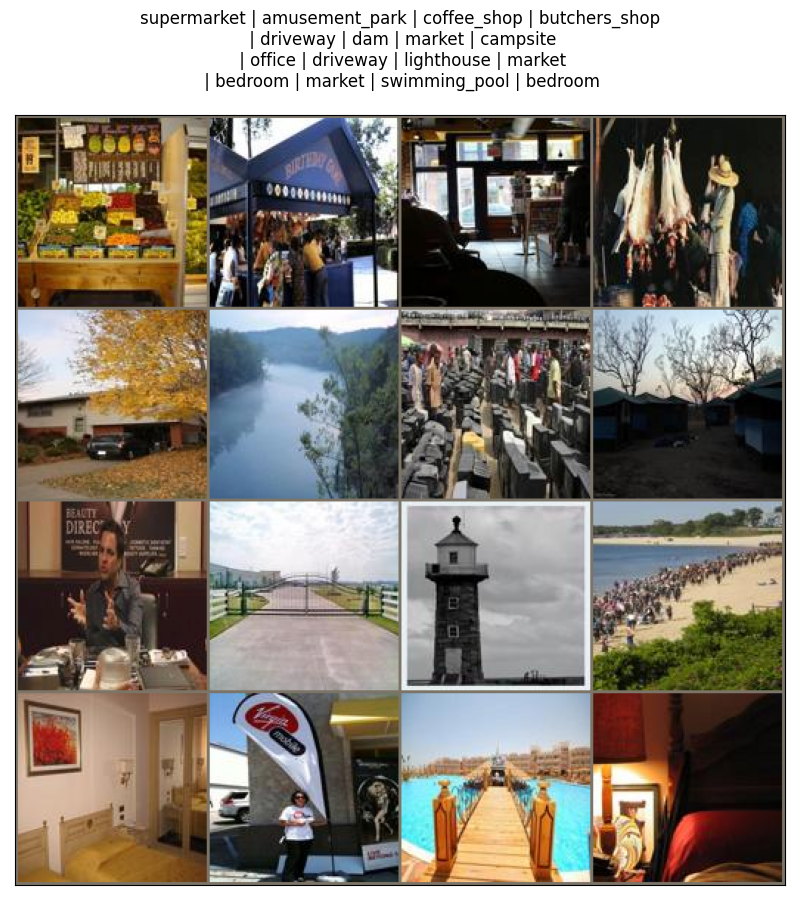

In [4]:
# Visualize the data within the dataset
import json
with open('./data_miniplaces_modified/category_names.json', 'r') as f:
    class_names = json.load(f)['i2c']
class_names = {i:name for i, name in enumerate(class_names)}

def imshow(inp, title=None, ax=None, figsize=(10, 10)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders_dict['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
title = [class_names[x.item()] if (i+1) % 4 != 0 else class_names[x.item()]+'\n' for i, x in enumerate(classes)]
imshow(out, title=' | '.join(title), ax=ax)

## Step 2. Build MiniVGG and MiniVGG-BN

Please follow the instructions to build the two neural networks with architectures shown.



In [5]:
# Helper function for counting number of trainable parameters.
def count_params(model):
    """
    Counts the number of trainable parameters in PyTorch.

    Args:
        model: PyTorch model.

    Returns:
        num_params: int, number of trainable parameters.
    """

    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])

    return num_params

In [6]:
# Network configurations for all layers before the final fully-connected layers. 
# "M" corresponds to maxpooling layer, integers correspond to number of output 
# channels of a convolutional layer.
cfgs = {
    'MiniVGG': [64, 'M', 128, 'M', 128, 128, 'M'],
    'MiniVGG-BN': [64, 'M', 128, 'M', 128, 128, 'M']
}

def make_layers(cfg, batch_norm=False):
    """
    Return a nn.Sequential object containing all layers to get the features 
    using the CNN. (That is, before the Average pooling layer in the two 
    pictures above). 

    Args:
      cfg: list
      batch_norm: bool, default: False. If set to True, a BatchNorm layer 
                  should be added after each convolutional layer.

    Return:
      features: torch.nn.Sequential. Containers for all feature extraction
                layers. For use of torch.nn.Sequential, please refer to 
                PyTorch documentation.
    """
    ###########################################################################
    # TODO: Construct the neural net architecture from cfg. You should use    #
    # nn.Sequential().                                                        #
    ###########################################################################

    if batch_norm:
        features = nn.Sequential(
            nn.Conv2d(3 ,cfg[0], kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(cfg[0], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(cfg[0], cfg[2], kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(cfg[2], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(cfg[2], cfg[4], kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(cfg[4], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(cfg[4], cfg[5], kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(cfg[5], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            )
    else:
        features = nn.Sequential(
            nn.Conv2d(3 ,cfg[0], kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(cfg[0], cfg[2], kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(cfg[2], cfg[4], kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(cfg[4], cfg[5], kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            )
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return features

class VGG(nn.Module):

    def __init__(self, features, num_classes=100, init_weights=True):
        super(VGG, self).__init__()

        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))

        #######################################################################
        # TODO: Construct the final FC layers using nn.Sequential.            #
        # Note: The average pooling layer has been defined by us above.       #
        #######################################################################        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=3200, out_features=512, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3, inplace=False),
            nn.Linear(in_features=512, out_features=256, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3, inplace=False),
            nn.Linear(in_features=256, out_features=100, bias=True)
        )
        #######################################################################
        #                              END OF YOUR CODE                       #
        #######################################################################

        if init_weights:
            self._initialize_weights()

    def forward(self, x): 
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [7]:
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
vgg = VGG(features)

features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
vgg_bn = VGG(features)

# Print the network architectrue. Please compare the printed architecture with 
# the one given in the instructions above. 
# Make sure your network has the same architecture as the one we give above.
print(vgg)
print('Number of trainable parameters {}'.format(count_params(vgg)))

print(vgg_bn)
print('Number of trainable parameters {}'.format(count_params(vgg_bn)))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (classifier): Sequential(
    (0): Linear(in_features=3200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=Tru

## Step 3. Build small ResNet model (EECS 504)

Please follow this figure to build the Residual Block and the Resnet model. We already implemented the back bone of the resnet model. You have to code the ResNet Block and the classifier part which are shown in ps.


In [8]:
# For EECS 504 students only other please delete/comment this cell

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1):
        super(ResidualBlock, self).__init__()
        ###########################################################################
        # TODO: Code the residual block as depicted in the above figure.
        #  You should use nn.Sequential().                                       #
        ###########################################################################
        if stride != 1:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
            self.dcp = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
            self.dcp = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        #######################################################################
        #                              END OF YOUR CODE                       #
        #######################################################################
        
    def forward(self, x):

        ###########################################################################
        # TODO: Code the forward pass for the residual block as depicted in the above figure. 
        # Note: The relu activation function is after the skip connection.                                                        #
        ###########################################################################

        dcp = self.dcp(x)
        x = nn.ReLU()(self.bn1(self.conv1(x)))
        x = nn.ReLU()(self.bn2(self.conv2(x)))
        x = x + dcp
        out = nn.ReLU()(x)
        #######################################################################
        #                              END OF YOUR CODE                       #
        #######################################################################
        return out

In [9]:
# For EECS 504 students only other please delete/comment this cell

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 100):
        super(ResNet, self).__init__()

        ###########################################################################
        # TODO: Construct the neural net architecture for the resnet model. You should use nn.Sequential().
        # Note: We already implemented most of the network you just need to code the initial layers and insert the residual blocks.
        ###########################################################################

        self.backbone = nn.Sequential(
                        ###########################################################################
                        # TODO: Code the initial layers i.e the the strided convolution layer, batchnorm, relu, maxpool layer and the residual blocks
                        #Hint: you have to make use of the "block" variable.
                        ###########################################################################
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                        block(64, 64),
                        block(64, 64),
                        #######################################################################
                        #                              END OF YOUR CODE                       #
                        #######################################################################
                        nn.Sequential(
                            nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1),
                            nn.BatchNorm2d(128),
                            nn.ReLU()
                        ),
                        ###########################################################################
                        # TODO: Inser the residual block please follow the figure for the number of channels and the flow of layers.
                        ###########################################################################
                        block(128, 128),
                        block(128, 128),
                        #######################################################################
                        #                              END OF YOUR CODE                       #
                        #######################################################################
                        nn.Sequential(
                            nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1),
                            nn.BatchNorm2d(256),
                            nn.ReLU()
                        ),
                        ###########################################################################
                        # TODO: Inser the residual block please follow the figure for the number of channels and the flow of layers.
                        ###########################################################################
                        block(256, 256),
                        block(256, 256),
                        #######################################################################
                        #                              END OF YOUR CODE                       #
                        #######################################################################
                        nn.Sequential(
                        nn.Conv2d(256, 512, kernel_size = 3, stride = 2, padding = 1),
                        nn.BatchNorm2d(512),
                        nn.ReLU()),
                        ###########################################################################
                        # TODO: Inser the residual block please follow the figure for the number of channels and the flow of layers.
                        ###########################################################################
                        block(512, 512),
                        block(512, 512)
                        #######################################################################
                        #                              END OF YOUR CODE                       #
                        #######################################################################
        )
        

        self.avgpool = nn.AvgPool2d(2, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    
    def forward(self, x):
        x = self.backbone(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [10]:
# For EECS 504 students only other please delete/comment this cell

resnet = ResNet(ResidualBlock, [1, 1, 1, 1], 100)
print(resnet)
print('Number of trainable parameters {}'.format(count_params(resnet)))


ResNet(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dcp): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dcp): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

## Step 4: Build training/validation loops

You will write a function for training and validating the network. 

In [11]:
def make_optimizer(model):
    """
    Args:
        model: NN to train

    Returns:
        optimizer: pytorch optmizer for updating the given model parameters.
    """
    ###########################################################################
    # TODO: Create a SGD optimizer with learning rate=1e-2 and momentum=0.9.  #
    # HINT: Check out optim.SGD() and initialize it with the appropriate      #
    # parameters. We have imported torch.optim as optim for you above.        #
    ###########################################################################
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################
    return optimizer

def get_loss():
    """
    Returns:
        criterion: pytorch loss. 
    """
    ###########################################################################
    # TODO: Create an instance of the cross entropy loss. This code           #
    # should be a one-liner.                                                  #
    ###########################################################################
    criterion = nn.CrossEntropyLoss()
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return criterion

In [12]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, num_epochs=25, model_name='MiniVGG'):
    """
    Args:
        model: The NN to train
        dataloaders: A dictionary containing at least the keys 
                    'train','val' that maps to Pytorch data loaders for the dataset
        criterion: The Loss function
        optimizer: Pytroch optimizer. The algorithm to update weights 
        num_epochs: How many epochs to train for
        save_dir: Where to save the best model weights that are found. Using None will not write anything to disk.

    Returns:
        model: The trained NN
        tr_acc_history: list, training accuracy history. Recording freq: one epoch.
        val_acc_history: list, validation accuracy history. Recording freq: one epoch.
    """

    val_acc_history = []
    tr_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # loss and number of correct prediction for the current batch
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                ###############################################################
                # TODO:                                                       #
                # Please read all the inputs carefully!                       #
                # For "train" phase:                                          #
                # (i)   Compute the outputs using the model                   #
                #       Also, use the outputs to calculate the class         #
                #       predicted by the model,                               #
                #       Store the predicted class in 'preds'                  #
                #       (Think: argmax of outputs across a dimension)         #
                #       torch.max() might help!                               #
                # (ii)  Use criterion to store the loss in 'loss'             # 
                # (iii) Update the model parameters                           #
                # Notes:                                                      #
                # - Don't forget to zero the gradients before beginning the   #
                # loop!                                                       #
                # - "val" phase is the same as train, but without backprop    #
                # - Compute the outputs (Same as "train", calculate 'preds'   #
                # too),                                                       #
                # - Calculate the loss and store it in 'loss'                 #
                ###############################################################
                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()
                ###############################################################
                #                         END OF YOUR CODE                    #
                ###############################################################

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                # save the best model weights
                # =========================================================== #
                # IMPORTANT:
                # Losing your connection to colab will lead to loss of trained 
                # weights.
                # You should download the trained weights to your local machine. 
                # Later, you can load these weights directly without needing to 
                # train the neural networks again.
                # =========================================================== #
                if save_dir:
                    torch.save(best_model_wts, os.path.join(save_dir, model_name + '.pth'))

            # record the train/val accuracies
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                tr_acc_history.append(epoch_acc)
                
    print('Best val Acc: {:4f}'.format(best_acc))

    return model, tr_acc_history, val_acc_history

## Step 5. Train MiniVGG / MiniVGG-BN and ResNet model (EECS 504)

In [13]:
# Number of classes in the dataset
# Miniplaces has 100
num_classes = 100

# Batch size for training 
batch_size = 128

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for
# During debugging, you can set this parameter to 1
# num_epochs = 1
# Training for 20 epochs. This will take about half an hour.
num_epochs = 10

### IO
# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# get dataloaders and criterion function
input_size = 64
dataloaders = get_dataloaders(input_size, batch_size, shuffle_datasets)
criterion = get_loss()

In [14]:
start_time = time.time()
# Initialize MiniVGG
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
model = VGG(features).to(device)
optimizer = make_optimizer(model)
# Train the model!
vgg, tr_his, val_his = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG')
print("~~~~~~~~~~ %s seconds ~~~~~~~~~~" % (time.time() - start_time))

Epoch 0/9
----------


100%|██████████| 352/352 [00:22<00:00, 15.54it/s]


train Loss: 4.6229 Acc: 0.0101


100%|██████████| 40/40 [00:02<00:00, 13.97it/s]


val Loss: 4.6219 Acc: 0.0152
Epoch 1/9
----------


100%|██████████| 352/352 [00:17<00:00, 19.71it/s]


train Loss: 4.5168 Acc: 0.0241


100%|██████████| 40/40 [00:01<00:00, 20.35it/s]


val Loss: 4.2969 Acc: 0.0356
Epoch 2/9
----------


100%|██████████| 352/352 [00:18<00:00, 19.50it/s]


train Loss: 4.2101 Acc: 0.0491


100%|██████████| 40/40 [00:02<00:00, 19.13it/s]


val Loss: 4.0650 Acc: 0.0699
Epoch 3/9
----------


100%|██████████| 352/352 [00:18<00:00, 18.64it/s]


train Loss: 3.9916 Acc: 0.0824


100%|██████████| 40/40 [00:02<00:00, 19.48it/s]


val Loss: 3.8437 Acc: 0.1107
Epoch 4/9
----------


100%|██████████| 352/352 [00:18<00:00, 18.55it/s]


train Loss: 3.7979 Acc: 0.1116


100%|██████████| 40/40 [00:01<00:00, 20.27it/s]


val Loss: 3.6706 Acc: 0.1304
Epoch 5/9
----------


100%|██████████| 352/352 [00:19<00:00, 17.62it/s]


train Loss: 3.6651 Acc: 0.1330


100%|██████████| 40/40 [00:02<00:00, 18.84it/s]


val Loss: 3.5426 Acc: 0.1539
Epoch 6/9
----------


100%|██████████| 352/352 [00:19<00:00, 18.08it/s]


train Loss: 3.5390 Acc: 0.1536


100%|██████████| 40/40 [00:02<00:00, 18.41it/s]


val Loss: 3.3939 Acc: 0.1765
Epoch 7/9
----------


100%|██████████| 352/352 [00:19<00:00, 17.80it/s]


train Loss: 3.4175 Acc: 0.1751


100%|██████████| 40/40 [00:02<00:00, 18.85it/s]


val Loss: 3.3453 Acc: 0.1838
Epoch 8/9
----------


100%|██████████| 352/352 [00:19<00:00, 17.88it/s]


train Loss: 3.3171 Acc: 0.1908


100%|██████████| 40/40 [00:02<00:00, 19.24it/s]


val Loss: 3.2261 Acc: 0.2004
Epoch 9/9
----------


100%|██████████| 352/352 [00:19<00:00, 18.43it/s]


train Loss: 3.2258 Acc: 0.2065


100%|██████████| 40/40 [00:02<00:00, 19.04it/s]

val Loss: 3.2144 Acc: 0.2131
Best val Acc: 0.213100
~~~~~~~~~~ 219.30145978927612 seconds ~~~~~~~~~~


In [15]:
start_time = time.time()
# Initialize MiniVGG-BN
features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
model = VGG(features).to(device)
optimizer = make_optimizer(model)
# Train the model!
vgg_BN, tr_his_BN, val_his_BN = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG-BN')
print("~~~~~~~~~~ %s seconds ~~~~~~~~~~" % (time.time() - start_time))

Epoch 0/9
----------


100%|██████████| 352/352 [00:21<00:00, 16.32it/s]


train Loss: 4.4551 Acc: 0.0223


100%|██████████| 40/40 [00:01<00:00, 20.09it/s]


val Loss: 4.1286 Acc: 0.0533
Epoch 1/9
----------


100%|██████████| 352/352 [00:21<00:00, 16.13it/s]


train Loss: 3.8950 Acc: 0.0840


100%|██████████| 40/40 [00:01<00:00, 20.27it/s]


val Loss: 3.7209 Acc: 0.1115
Epoch 2/9
----------


100%|██████████| 352/352 [00:21<00:00, 16.00it/s]


train Loss: 3.6081 Acc: 0.1300


100%|██████████| 40/40 [00:02<00:00, 15.69it/s]


val Loss: 3.5457 Acc: 0.1441
Epoch 3/9
----------


100%|██████████| 352/352 [00:22<00:00, 15.94it/s]


train Loss: 3.4036 Acc: 0.1638


100%|██████████| 40/40 [00:02<00:00, 17.70it/s]


val Loss: 3.2955 Acc: 0.1850
Epoch 4/9
----------


100%|██████████| 352/352 [00:21<00:00, 16.07it/s]


train Loss: 3.2669 Acc: 0.1912


100%|██████████| 40/40 [00:02<00:00, 18.82it/s]


val Loss: 3.3168 Acc: 0.1930
Epoch 5/9
----------


100%|██████████| 352/352 [00:21<00:00, 16.06it/s]


train Loss: 3.1574 Acc: 0.2111


100%|██████████| 40/40 [00:02<00:00, 19.06it/s]


val Loss: 3.0937 Acc: 0.2218
Epoch 6/9
----------


100%|██████████| 352/352 [00:21<00:00, 16.03it/s]


train Loss: 3.0727 Acc: 0.2291


100%|██████████| 40/40 [00:02<00:00, 17.86it/s]


val Loss: 3.0503 Acc: 0.2335
Epoch 7/9
----------


100%|██████████| 352/352 [00:22<00:00, 15.86it/s]


train Loss: 2.9927 Acc: 0.2435


100%|██████████| 40/40 [00:02<00:00, 18.10it/s]


val Loss: 2.9967 Acc: 0.2437
Epoch 8/9
----------


100%|██████████| 352/352 [00:22<00:00, 15.70it/s]


train Loss: 2.9161 Acc: 0.2607


100%|██████████| 40/40 [00:02<00:00, 13.65it/s]


val Loss: 2.9397 Acc: 0.2611
Epoch 9/9
----------


100%|██████████| 352/352 [00:22<00:00, 15.84it/s]


train Loss: 2.8455 Acc: 0.2726


100%|██████████| 40/40 [00:02<00:00, 18.08it/s]

val Loss: 2.8479 Acc: 0.2745
Best val Acc: 0.274500
~~~~~~~~~~ 242.97222447395325 seconds ~~~~~~~~~~


In [16]:
# For EECS 504 students only other please delete/comment this cell
start_time = time.time()
# Initialize ResNet
resnet = ResNet(ResidualBlock, [1, 1, 1, 1], num_classes).to(device)
optimizer = make_optimizer(resnet)
# Train the model!
resnet, tr_his_res, val_his_res = train_model(model=resnet, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='ResNet')
print("~~~~~~~~~~ %s seconds ~~~~~~~~~~" % (time.time() - start_time))

Epoch 0/9
----------


100%|██████████| 352/352 [00:19<00:00, 17.95it/s]


train Loss: 3.7804 Acc: 0.1217


100%|██████████| 40/40 [00:02<00:00, 17.51it/s]


val Loss: 3.5126 Acc: 0.1620
Epoch 1/9
----------


100%|██████████| 352/352 [00:18<00:00, 19.04it/s]


train Loss: 3.2268 Acc: 0.2098


100%|██████████| 40/40 [00:01<00:00, 20.15it/s]


val Loss: 3.3139 Acc: 0.2082
Epoch 2/9
----------


100%|██████████| 352/352 [00:18<00:00, 18.60it/s]


train Loss: 2.9150 Acc: 0.2696


100%|██████████| 40/40 [00:02<00:00, 17.95it/s]


val Loss: 3.3869 Acc: 0.1977
Epoch 3/9
----------


100%|██████████| 352/352 [00:19<00:00, 18.10it/s]


train Loss: 2.6772 Acc: 0.3137


100%|██████████| 40/40 [00:02<00:00, 19.00it/s]


val Loss: 3.0609 Acc: 0.2618
Epoch 4/9
----------


100%|██████████| 352/352 [00:19<00:00, 18.50it/s]


train Loss: 2.4367 Acc: 0.3644


100%|██████████| 40/40 [00:01<00:00, 20.12it/s]


val Loss: 3.0054 Acc: 0.2667
Epoch 5/9
----------


100%|██████████| 352/352 [00:18<00:00, 19.23it/s]


train Loss: 2.2031 Acc: 0.4145


100%|██████████| 40/40 [00:02<00:00, 19.24it/s]


val Loss: 3.0289 Acc: 0.2717
Epoch 6/9
----------


100%|██████████| 352/352 [00:19<00:00, 17.93it/s]


train Loss: 1.9405 Acc: 0.4715


100%|██████████| 40/40 [00:02<00:00, 19.45it/s]


val Loss: 3.0887 Acc: 0.2752
Epoch 7/9
----------


100%|██████████| 352/352 [00:19<00:00, 18.29it/s]


train Loss: 1.6625 Acc: 0.5364


100%|██████████| 40/40 [00:02<00:00, 18.29it/s]


val Loss: 3.3115 Acc: 0.2638
Epoch 8/9
----------


100%|██████████| 352/352 [00:19<00:00, 18.23it/s]


train Loss: 1.3697 Acc: 0.6086


100%|██████████| 40/40 [00:02<00:00, 19.02it/s]


val Loss: 3.4592 Acc: 0.2606
Epoch 9/9
----------


100%|██████████| 352/352 [00:19<00:00, 18.28it/s]


train Loss: 1.0541 Acc: 0.6928


100%|██████████| 40/40 [00:02<00:00, 16.52it/s]

val Loss: 3.6772 Acc: 0.2547
Best val Acc: 0.275200
~~~~~~~~~~ 213.3528962135315 seconds ~~~~~~~~~~


In [ ]:
x = np.arange(num_epochs)
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, torch.tensor(tr_his, device = 'cpu'))
plt.plot(x, torch.tensor(val_his, device = 'cpu'))
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG')
plt.show()

# train/val accuracies for MiniVGG-BN
plt.plot(x, torch.tensor(tr_his_BN, device = 'cpu'))
plt.plot(x, torch.tensor(val_his_BN, device = 'cpu'))
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG-BN')
plt.show()

# compare val accuracies of MiniVGG and MiniVGG-BN
plt.plot(x, torch.tensor(val_his, device = 'cpu'))
plt.plot(x, torch.tensor(val_his_BN, device = 'cpu'))
plt.legend(['MiniVGG', 'MiniVGG-BN'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('Compare')
plt.show()

In [ ]:
# For EECS 504 students only other please delete/comment this cell

# train/val accuracies for ResNet
plt.figure()
plt.plot(x, torch.tensor(tr_his_res, device = 'cpu'))
plt.plot(x, torch.tensor(val_his_res, device = 'cpu'))
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('ResNet')
plt.show()

In [ ]:
# batch normalization slightly increase the accuracy of training

### TODO: __Summarize the effect of batch normalization:__







In [ ]:
pickle.dump(tr_his, open('tr_his.pkl', 'wb'))
pickle.dump(tr_his_BN, open('tr_his_BN.pkl', 'wb'))
pickle.dump(val_his, open('val_his.pkl', 'wb'))
pickle.dump(val_his_BN, open('val_his_BN.pkl', 'wb'))

In [ ]:
pickle.dump(tr_his_res, open('tr_his_res.pkl', 'wb'))
pickle.dump(val_his_res, open('val_his_res.pkl', 'wb'))

## Step 6. Measure top1 and top5 accuracies of MiniVGG and MiniVGG-BN

__Definition of top-k accuracy__: if the correct label is within the _top k_ predicted classes according to the network output scores, we count the prediction by the neural network as a correct prediction.

In [ ]:
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values 
    of k.
    
    Args:
        output: pytorch tensor, (batch_size x num_classes). Outputs of the 
                network for one batch.
        target: pytorch tensor, (batch_size,). True labels for one batch.
    
    Returns:
        res: list. Accuracies corresponding to topk[0], topk[1], ...
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def test(model, dataloader):

    model.eval()

    top1_acc = []
    top5_acc = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            res = accuracy(outputs, labels, topk=(1, 5))

            top1_acc.append(res[0] * len(outputs))
            top5_acc.append(res[1] * len(outputs))

    print('Top-1 accuracy {}%, Top-5 accuracy {}%'.format(sum(top1_acc).item()/10000, sum(top5_acc).item()/10000))

In [ ]:
##### To pass the test, both networks should have Top-5 accuracy above 55% #####
vgg_BN.load_state_dict(torch.load('./weights/MiniVGG-BN.pth'))
vgg.load_state_dict(torch.load('./weights/MiniVGG.pth'))

test(vgg_BN, dataloaders['test'])
test(vgg, dataloaders['test'])

In [ ]:
##### To pass the test, both networks should have Top-5 accuracy above 55% #####

# For EECS 504 students only other please delete/comment this cell

resnet.load_state_dict(torch.load('./weights/ResNet.pth'))
test(resnet, dataloaders['test'])

In [ ]:
##### Download pretrained weights (TODO: remove for student version) #####

# !wget http://www.eecs.umich.edu/courses/eecs504/MiniVGG-BN.pth
# !wget http://www.eecs.umich.edu/courses/eecs504/MiniVGG.pth

# features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
# vgg_BN = VGG(features).to(device)

# features = make_layers(cfgs['MiniVGG'], batch_norm=False)
# vgg = VGG(features).to(device)

# vgg_BN.load_state_dict(torch.load('MiniVGG-BN.pth'))
# vgg.load_state_dict(torch.load('MiniVGG.pth'))

# test(vgg_BN, dataloaders['test'])
# test(vgg, dataloaders['test'])